### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Increase data frame column width:
pd.set_option('max_colwidth', 400)

import re

# natto-py
import natto
from natto import MeCab

# for sentiment analysis
# oseti
import oseti
# asari
from asari.api import Sonar

# for quantifying results
from sklearn.metrics import classification_report, mean_absolute_error

import os
# this explicitly tells python where to find the MeCab dictionary
# replace with the path to the libmecab.dll if you get an error running the MeCab() instantiation below
os.environ['MECAB_PATH']="C:/Program Files/MeCab/bin/libmecab.dll"
# we need to force MeCab to read Japanese text in UTF-8
os.environ['MECAB_CHARSET']='utf-8'

First, we import the dataframe we exported in the previous EDA notebook with the sentiment scores.

In [2]:
japanese_reviews_sentiments_df = pd.read_csv('../datasets/rakuten_tohoku_reviews_sentiments.csv')

In [3]:
japanese_reviews_sentiments_df.head()

,review_id,review_time,review_text,hotel_reply_time,hotel_reply_text,hotel_name,prefecture,overall_score,service_score,location_score,...,amenities_sentiment_asari,bathroom_sentiment_asari,food_sentiment_asari,overall_sentiment_oseti,service_sentiment_oseti,location_sentiment_oseti,room_sentiment_oseti,amenities_sentiment_oseti,bathroom_sentiment_oseti,food_sentiment_oseti
0,voteans_21301527,2024-02-18 01:26:29,家族でのんびり過ごせて良かったです。お料理が美味しかったし、景色も美しかったです。温泉は思ったよりも小さかったですが、泉質は結構よかった。,NaN,NaN,鶴の舞橋と岩木山 絶景の宿 つがる富士見荘,aomori,4,4,4,...,0.0,0.967200,0.887214,1.000000,0.000000,0.0,0.000000,0.0,1.000000,1.000000
1,voteans_21251321,2024-01-29 12:03:50,ロビーからの鶴の舞橋の景観が素晴らしく、雪景色もあって楽しめました。食事も満腹となるほどの量・品数があり、いずれも美味でした。近くに鶴の飼育もなされており、鶴の鳴き合いの声を聴きながらの散策も特別な雰囲気を感じました。、,2024-02-15 18:11:20,この度は当館にご宿泊いただき誠にありがとうございます。ロビーから見える鶴の舞橋と雪化粧した岩木山の姿は、私共も見ていて飽きないほどです。また、お食事の面でもお客様にご満足いただけたようで大変嬉しく思います。丹頂鶴自然公園は1年を通して鶴とのふれあいを楽しめますので、ご機会がございましたらまたのお越しを心よりお待ち申し上げております。,鶴の舞橋と岩木山 絶景の宿 つがる富士見荘,aomori,4,4,5,...,0.0,0.000000,0.669060,0.750000,0.000000,1.0,0.000000,0.0,0.000000,1.000000
2,voteans_21170325,2023-12-26 15:04:31,先日はお世話になりました。夕食を部屋食への変更、ありがとうございました。お食事はとても味付けが良くて、量も適量で、本当にゆっくりと食事が出来て良かったです。大浴場のお湯も、しっとりとしてかけ流しのお湯は気持ち良かったです。なかなか遠いのでまたチャンスがあれば伺いたいと思います。鶴の舞橋が目の前で、圧巻でした。雪が舞い散る鶴の舞橋も幻想的でとても良かったです。また足を運びたいと思います。ありがとうございました。,NaN,NaN,鶴の舞橋と岩木山 絶景の宿 つがる富士見荘,aomori,4,5,5,...,0.0,0.615004,0.977256,0.333333,0.000000,0.0,0.000000,0.0,1.000000,0.500000
3,voteans_21061209,2023-11-21 16:12:52,大変満足でした。お掃除も行き届いていましたしお料理も美味しかったです。お風呂のお湯も豊富で気持ちよかったです。とにかく鶴の舞橋が目の前で素晴らしかったです。,NaN,NaN,鶴の舞橋と岩木山 絶景の宿 つがる富士見荘,aomori,5,4,5,...,0.0,0.909405,0.859946,0.750000,0.000000,0.0,0.000000,0.0,1.000000,1.000000
4,voteans_21031432,2023-11-12 19:16:54,【良かった点】・部屋から見える景色が素晴らしく大満足。・フロントの対応が丁寧。【気になった点】・全室禁煙を知らなかった（当方の確認不足もあるが）予約時に禁煙や喫煙の記載がなかったので気にしてなかったが、部屋に灰皿がないのでフロントに電話で聞いたところ、全室禁煙とのこと。施設外まで出る必要があり、イマイチのんびり出来なかった。・部屋の髪の毛白いソファーに長い髪の毛が2本。ソファーが白なので目立ちました。・食事の質とサービス食事の質は普通であり、量もちょうどよかったが、質は宿泊料金に見合ってないように感じた。食事会場では係の方全員が厨房側に入り、会場に誰もいない時間が多々あった。飲み物を追加したいが、係の人が来るまで5分程度待った（大声で呼ぶことも考えたが、周囲のお客様に迷惑と思った）。朝食は席に着いても説明がなく戸惑った。・感染対策浴場と脱衣所でマスクなしでの会話が目立つ（地元の日帰...,NaN,NaN,鶴の舞橋と岩木山 絶景の宿 つがる富士見荘,aomori,2,2,5,...,0.0,0.434869,0.079664,0.179167,0.177778,0.0,0.106667,0.0,0.166667,-0.333333


### Time Series Analysis

Let us look at how the sentiments and ratings for each aspect vary with time.

First, we need to make sure that our timestamps are in the correct format.

In [4]:
japanese_reviews_sentiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7330 entries, 0 to 7329
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   review_id                  7330 non-null   object 
 1   review_time                7330 non-null   object 
 2   review_text                7330 non-null   object 
 3   hotel_reply_time           6260 non-null   object 
 4   hotel_reply_text           6260 non-null   object 
 5   hotel_name                 7330 non-null   object 
 6   prefecture                 7330 non-null   object 
 7   overall_score              7330 non-null   int64  
 8   service_score              7330 non-null   int64  
 9   location_score             7330 non-null   int64  
 10  room_score                 7330 non-null   int64  
 11  amenities_score            7305 non-null   float64
 12  bathroom_score             7009 non-null   float64
 13  food_score                 5714 non-null   float

Let us first convert the `review_time` and `hotel_reply_time` columns to datetime.

In [5]:
japanese_reviews_sentiments_df['review_time'] = pd.to_datetime(japanese_reviews_sentiments_df['review_time'])
japanese_reviews_sentiments_df['hotel_reply_time'] = pd.to_datetime(japanese_reviews_sentiments_df['hotel_reply_time'])

In [6]:
japanese_reviews_sentiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7330 entries, 0 to 7329
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   review_id                  7330 non-null   object        
 1   review_time                7330 non-null   datetime64[ns]
 2   review_text                7330 non-null   object        
 3   hotel_reply_time           6260 non-null   datetime64[ns]
 4   hotel_reply_text           6260 non-null   object        
 5   hotel_name                 7330 non-null   object        
 6   prefecture                 7330 non-null   object        
 7   overall_score              7330 non-null   int64         
 8   service_score              7330 non-null   int64         
 9   location_score             7330 non-null   int64         
 10  room_score                 7330 non-null   int64         
 11  amenities_score            7305 non-null   float64       
 12  bathro

In [7]:
japanese_reviews_sentiments_df.head()

,review_id,review_time,review_text,hotel_reply_time,hotel_reply_text,hotel_name,prefecture,overall_score,service_score,location_score,...,amenities_sentiment_asari,bathroom_sentiment_asari,food_sentiment_asari,overall_sentiment_oseti,service_sentiment_oseti,location_sentiment_oseti,room_sentiment_oseti,amenities_sentiment_oseti,bathroom_sentiment_oseti,food_sentiment_oseti
0,voteans_21301527,2024-02-18 01:26:29,家族でのんびり過ごせて良かったです。お料理が美味しかったし、景色も美しかったです。温泉は思ったよりも小さかったですが、泉質は結構よかった。,NaT,NaN,鶴の舞橋と岩木山 絶景の宿 つがる富士見荘,aomori,4,4,4,...,0.0,0.967200,0.887214,1.000000,0.000000,0.0,0.000000,0.0,1.000000,1.000000
1,voteans_21251321,2024-01-29 12:03:50,ロビーからの鶴の舞橋の景観が素晴らしく、雪景色もあって楽しめました。食事も満腹となるほどの量・品数があり、いずれも美味でした。近くに鶴の飼育もなされており、鶴の鳴き合いの声を聴きながらの散策も特別な雰囲気を感じました。、,2024-02-15 18:11:20,この度は当館にご宿泊いただき誠にありがとうございます。ロビーから見える鶴の舞橋と雪化粧した岩木山の姿は、私共も見ていて飽きないほどです。また、お食事の面でもお客様にご満足いただけたようで大変嬉しく思います。丹頂鶴自然公園は1年を通して鶴とのふれあいを楽しめますので、ご機会がございましたらまたのお越しを心よりお待ち申し上げております。,鶴の舞橋と岩木山 絶景の宿 つがる富士見荘,aomori,4,4,5,...,0.0,0.000000,0.669060,0.750000,0.000000,1.0,0.000000,0.0,0.000000,1.000000
2,voteans_21170325,2023-12-26 15:04:31,先日はお世話になりました。夕食を部屋食への変更、ありがとうございました。お食事はとても味付けが良くて、量も適量で、本当にゆっくりと食事が出来て良かったです。大浴場のお湯も、しっとりとしてかけ流しのお湯は気持ち良かったです。なかなか遠いのでまたチャンスがあれば伺いたいと思います。鶴の舞橋が目の前で、圧巻でした。雪が舞い散る鶴の舞橋も幻想的でとても良かったです。また足を運びたいと思います。ありがとうございました。,NaT,NaN,鶴の舞橋と岩木山 絶景の宿 つがる富士見荘,aomori,4,5,5,...,0.0,0.615004,0.977256,0.333333,0.000000,0.0,0.000000,0.0,1.000000,0.500000
3,voteans_21061209,2023-11-21 16:12:52,大変満足でした。お掃除も行き届いていましたしお料理も美味しかったです。お風呂のお湯も豊富で気持ちよかったです。とにかく鶴の舞橋が目の前で素晴らしかったです。,NaT,NaN,鶴の舞橋と岩木山 絶景の宿 つがる富士見荘,aomori,5,4,5,...,0.0,0.909405,0.859946,0.750000,0.000000,0.0,0.000000,0.0,1.000000,1.000000
4,voteans_21031432,2023-11-12 19:16:54,【良かった点】・部屋から見える景色が素晴らしく大満足。・フロントの対応が丁寧。【気になった点】・全室禁煙を知らなかった（当方の確認不足もあるが）予約時に禁煙や喫煙の記載がなかったので気にしてなかったが、部屋に灰皿がないのでフロントに電話で聞いたところ、全室禁煙とのこと。施設外まで出る必要があり、イマイチのんびり出来なかった。・部屋の髪の毛白いソファーに長い髪の毛が2本。ソファーが白なので目立ちました。・食事の質とサービス食事の質は普通であり、量もちょうどよかったが、質は宿泊料金に見合ってないように感じた。食事会場では係の方全員が厨房側に入り、会場に誰もいない時間が多々あった。飲み物を追加したいが、係の人が来るまで5分程度待った（大声で呼ぶことも考えたが、周囲のお客様に迷惑と思った）。朝食は席に着いても説明がなく戸惑った。・感染対策浴場と脱衣所でマスクなしでの会話が目立つ（地元の日帰...,NaT,NaN,鶴の舞橋と岩木山 絶景の宿 つがる富士見荘,aomori,2,2,5,...,0.0,0.434869,0.079664,0.179167,0.177778,0.0,0.106667,0.0,0.166667,-0.333333


In [8]:
# for convenience
ratings_columns = [col for col in japanese_reviews_sentiments_df.columns.tolist() if 'score' in col]
sentiment_columns = [col for col in japanese_reviews_sentiments_df.columns.tolist() if 'sentiment' in col]

Let us look at the trends of the sentiments for Hotel Sunroute Aomori (ホテルサンルート青森).

In [9]:
hotel_sunroute_aomori_df = japanese_reviews_sentiments_df[japanese_reviews_sentiments_df['hotel_name']=='ホテルサンルート青森'].copy()

In [10]:
hotel_sunroute_aomori_df.shape

(40, 28)

We first set the `review_time` column as the index.

In [11]:
hotel_sunroute_aomori_df.set_index('review_time', inplace=True)

In [12]:
hotel_sunroute_aomori_ratings_df = hotel_sunroute_aomori_df[ratings_columns].copy()
hotel_sunroute_aomori_sentiments_df = hotel_sunroute_aomori_df[sentiment_columns].copy()

Text(0.5, 1.0, 'Sentiments across time')

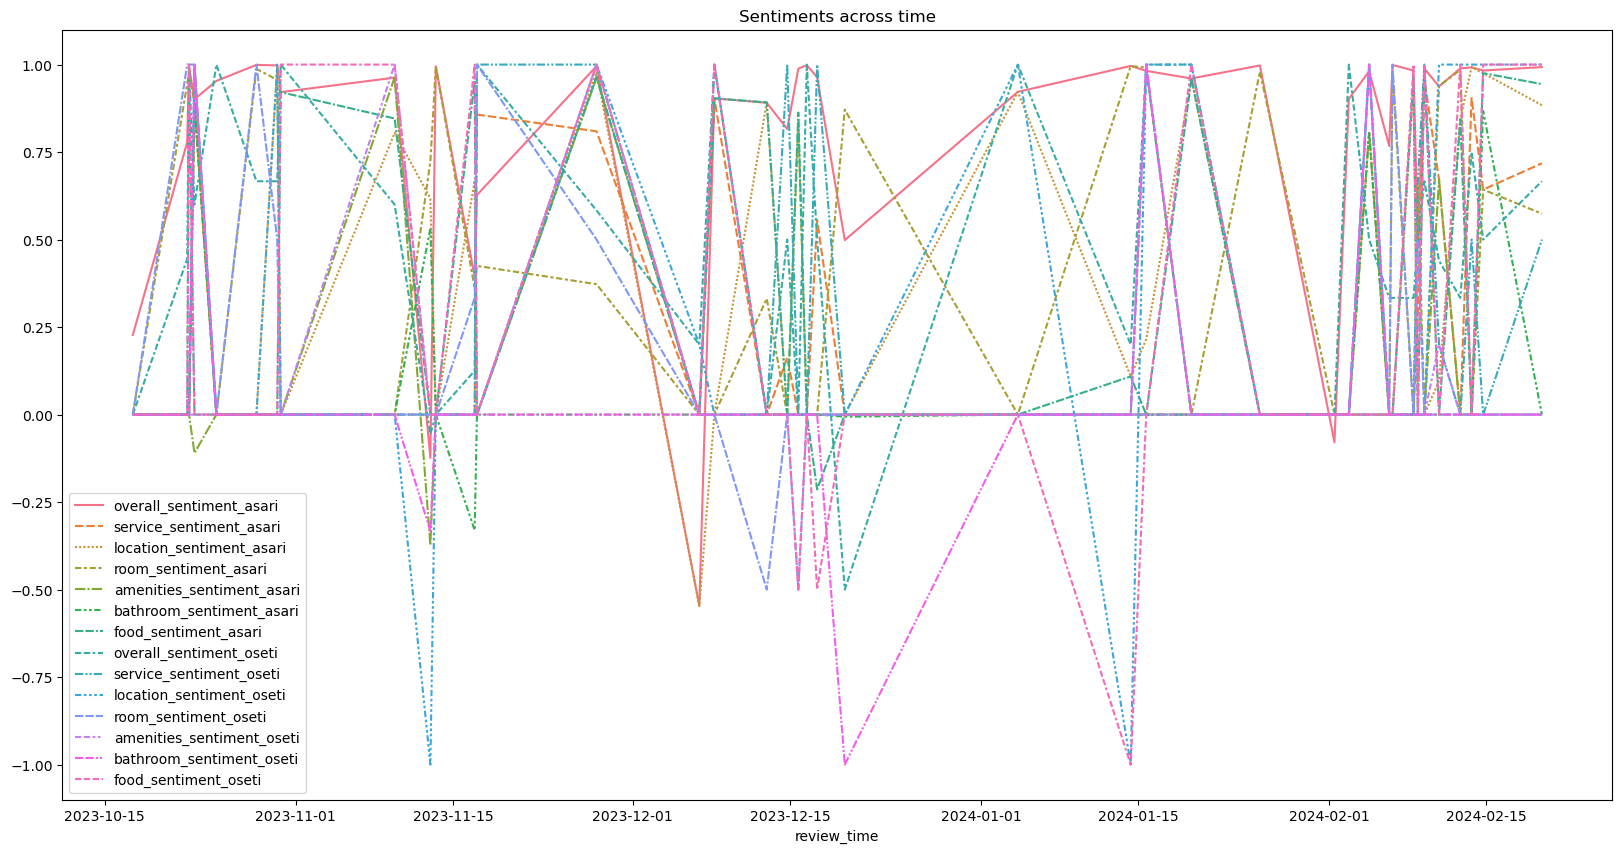

In [13]:
plt.figure(figsize=(20,10))
sns.lineplot(hotel_sunroute_aomori_sentiments_df)
plt.title('Sentiments across time')

Text(0.5, 1.0, 'Ratings across time')

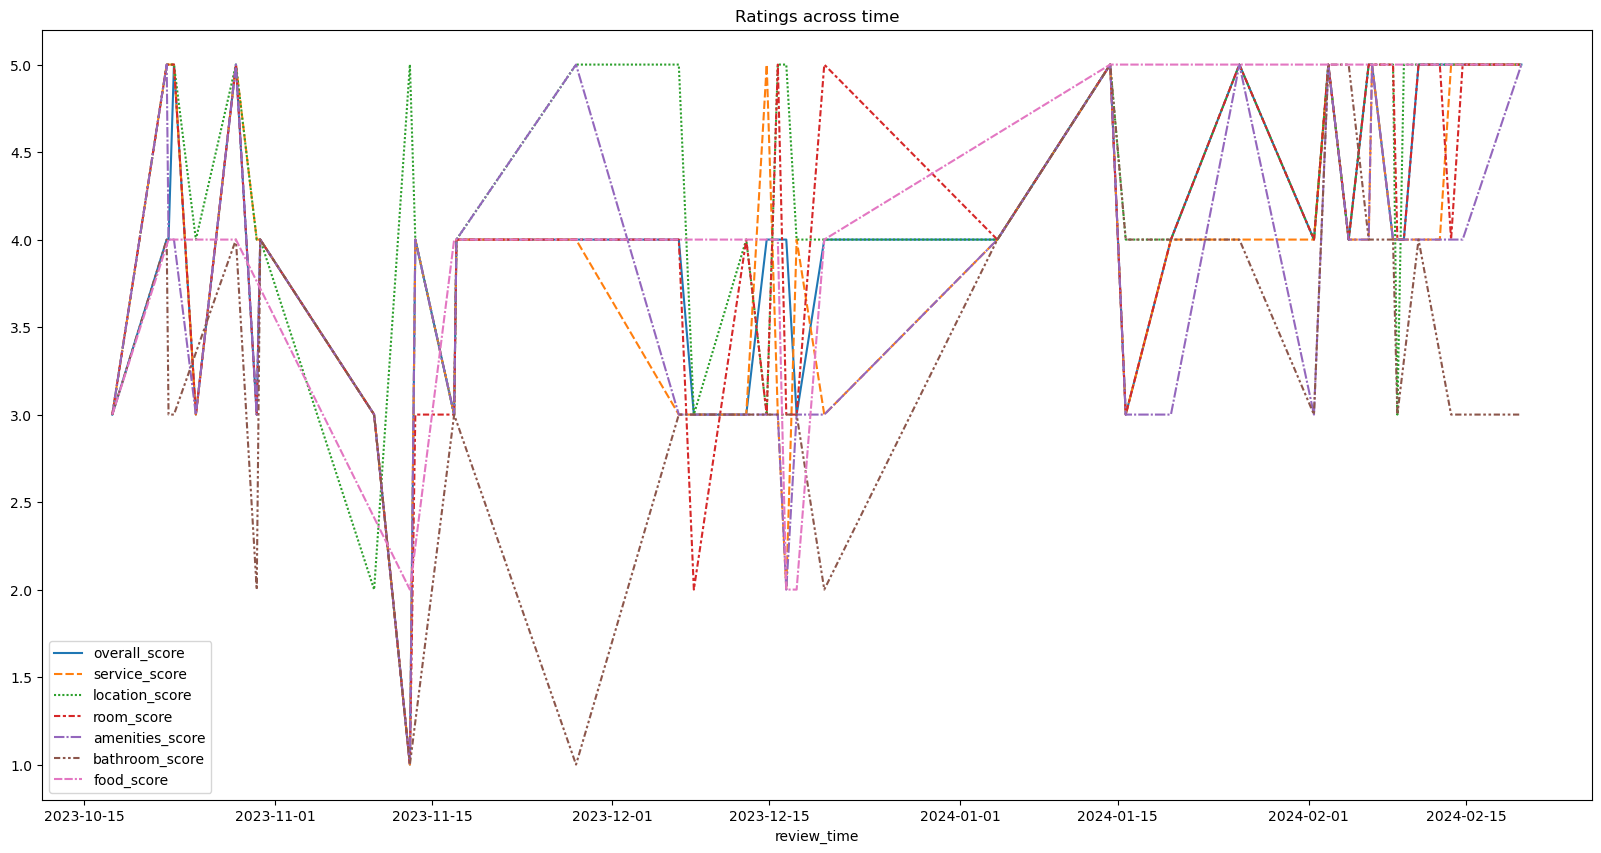

In [14]:
plt.figure(figsize=(20,10))
sns.lineplot(hotel_sunroute_aomori_ratings_df)
plt.title('Ratings across time')

We can also check how correlated the sentiments and the given scores are.

In [15]:
aspect_list = ['overall', 'service', 'location', 'room', 'amenities', 'bathroom', 'food']

In [16]:
{aspect: hotel_sunroute_aomori_df[[f'{aspect}_score', f'{aspect}_sentiment_asari']].corr().to_numpy()[0,1] for aspect in aspect_list}

{'overall': 0.3718907711329491,
 'service': 0.25631953230969795,
 'location': -0.00444125650236946,
 'room': 0.33532151933539217,
 'amenities': 0.20089284656017106,
 'bathroom': 0.06770656427096851,
 'food': 0.5594469108759159}

In [17]:
def plot_rating_sentiment_comparison(dataframe: pd.DataFrame, aspect: str):
    '''Plots line graphs of ratings and sentiments for `aspect` aspect.
    '''

    # this scales the scores from a range of 1 to 5, to a range of -1 to 1
    temp_df = dataframe.copy()
    temp_df[f'{aspect}_score'] = [0.5*(score - 3) for score in temp_df[f'{aspect}_score'].values.tolist()]

    plt.figure(figsize=(20,10))
    sns.lineplot(temp_df[[f'{aspect}_score', f'{aspect}_sentiment_asari', f'{aspect}_sentiment_oseti']])
    plt.title(f'{aspect.capitalize()} ratings and sentiment comparison')

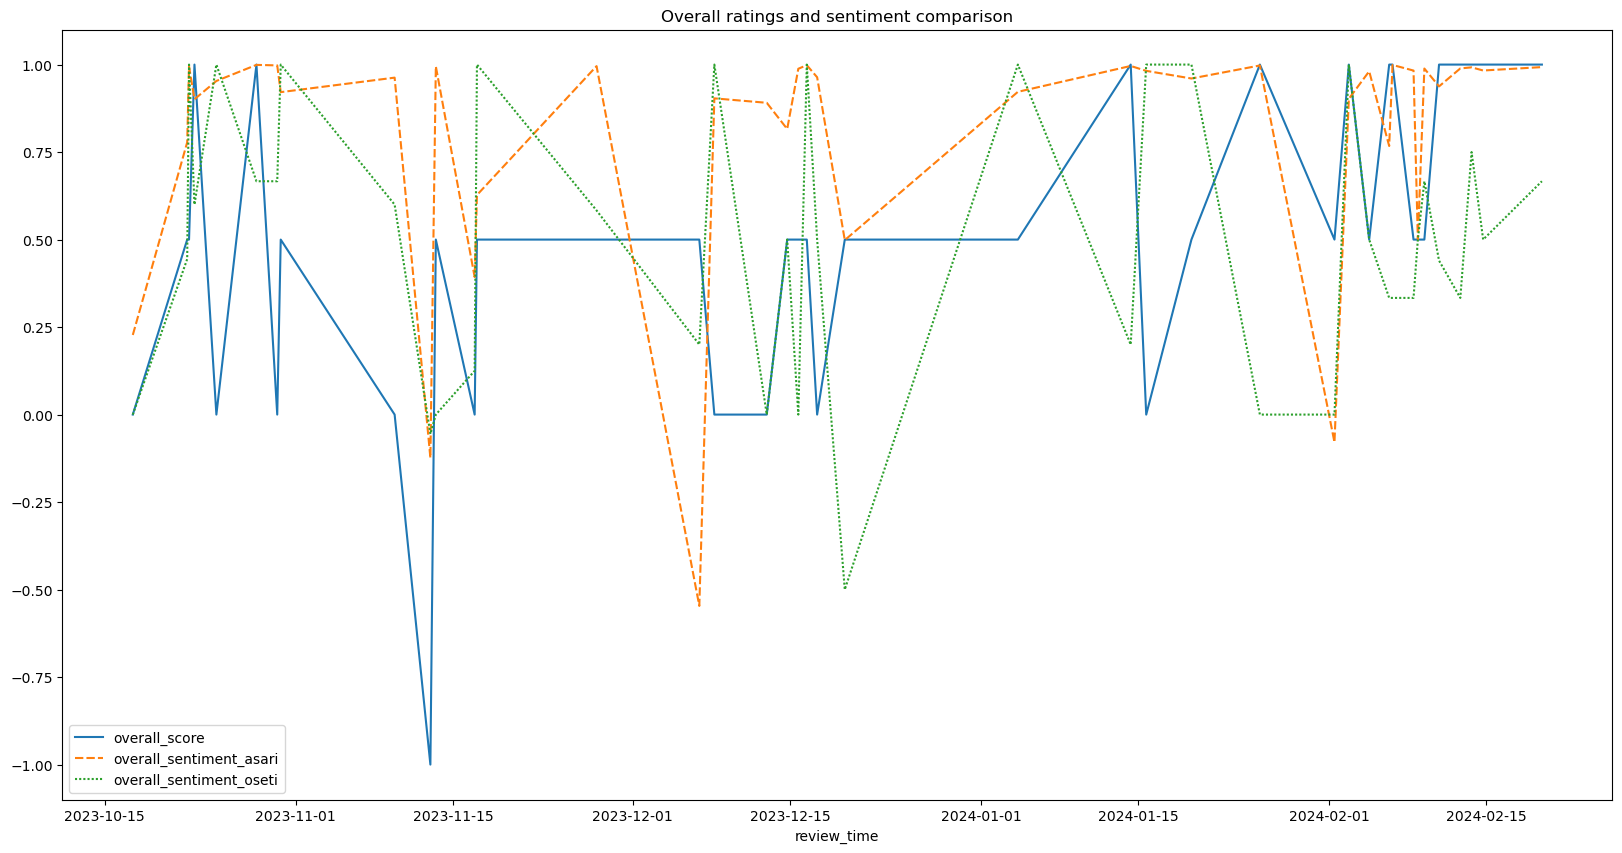

In [18]:
plot_rating_sentiment_comparison(hotel_sunroute_aomori_df, 'overall')

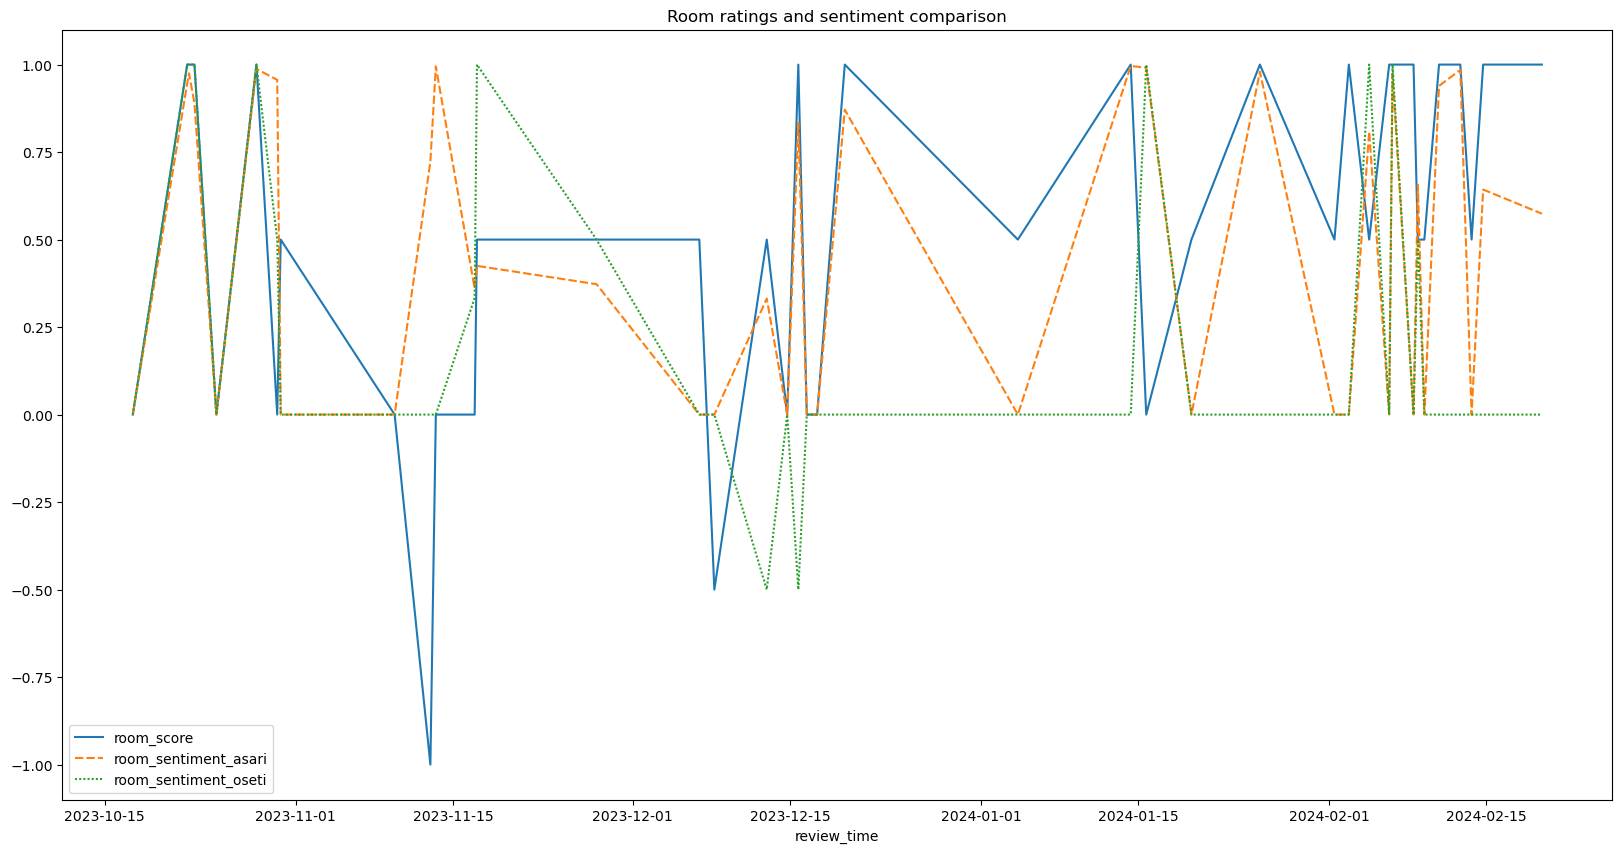

In [19]:
plot_rating_sentiment_comparison(hotel_sunroute_aomori_df, 'room')

We see something interesting going on here where the actual score for that aspect is a lot lower than the predicted sentiment. Let us take a look at what is going on.

In [20]:
hotel_sunroute_aomori_df[hotel_sunroute_aomori_df['room_score'] == 1.0]

,review_id,review_text,hotel_reply_time,hotel_reply_text,hotel_name,prefecture,overall_score,service_score,location_score,room_score,...,amenities_sentiment_asari,bathroom_sentiment_asari,food_sentiment_asari,overall_sentiment_oseti,service_sentiment_oseti,location_sentiment_oseti,room_sentiment_oseti,amenities_sentiment_oseti,bathroom_sentiment_oseti,food_sentiment_oseti
review_time,,,,,,,,,,,,,,,,,,,,,
2023-11-12 23:49:28,voteans_21032225,お部屋おまかせで予約をしました。部屋のドアを開けると凄く広い部屋でした。洗面所の前に椅子が2つありました。ひとつは普通にビジホにある様な椅子で、もうひとつは介護が必要な人が使うような椅子。それをみて違和感をおぼえました。部屋の中やトイレ、お風呂をじっくりみてみるとバリアフリーの部屋でした。まるで介護施設か病院の個室にいるような感じでした。約10日間の旅行の内の1日だけのホテルでしたが、旅行の楽しい気分が台無しになりました。その椅子を見ると気分悪くなるので見えない入口に移動させました。お風呂も入る気になれなかった。年齢が70超えているのなら納得しますがそこまで老いていないのにこの部屋。めちゃくちゃ居心地悪かった。気分だだ下がり。後、ベットの上にナイトウエアバスタオル、スリッパ等置いてあるのも違和感です。バスタオルがベッドの上にあるとうっかりお風呂入ってしまうと濡れた状態でバスタオル取...,2023-11-20 07:19:57,この度は、ホテルサンルート青森をご利用頂きまして誠に有難うございました。ご案内したお部屋がお客様に大変な不快感を与えた事をお詫び致します。ご案内したお部屋は、バリアフリーとはご案内できませんが、お風呂・トイレが別のお部屋です。38㎡のお部屋で禁煙・喫煙で2部屋のご準備が有ります。客室からの眺望は絶景です。・・・が、お客様が不快に思われた椅子は必要に応じて客室に入れるよう変更しました。ベッドの上のナイトウエア等ですが、以前はＵＢ内に設置しておりました。お客様からの「タオルセットが無い」との内線・お声が大変多く、見える箇所に設置しております。コーヒーの件はコンビニまで行かれるよりは、「100円でどうぞ」と言うコンセプトです。いろいろ不愉快に感じると事があり大変申し訳けございませんでした。お忙しい中、貴重なご意見を頂き有難うございました。,ホテルサンルート青森,aomori,1,1,5,1,...,-0.372587,0.532743,0.0,-0.055556,0.0,-1.0,0.0,0.0,-0.333333,0.0


In [21]:
mismatched_room_review = hotel_sunroute_aomori_df[hotel_sunroute_aomori_df['room_score'] == 1.0]['review_text'].values[0]

In [22]:
# initializing the sentiment analyzer
sonar = Sonar()

In [23]:
# checking the overall sentiment
sonar.ping(mismatched_room_review)

{'text': 'お部屋おまかせで予約をしました。部屋のドアを開けると凄く広い部屋でした。洗面所の前に椅子が2つありました。ひとつは普通にビジホにある様な椅子で、もうひとつは介護が必要な人が使うような椅子。それをみて違和感をおぼえました。部屋の中やトイレ、お風呂をじっくりみてみるとバリアフリーの部屋でした。まるで介護施設か病院の個室にいるような感じでした。約10日間の旅行の内の1日だけのホテルでしたが、旅行の楽しい気分が台無しになりました。その椅子を見ると気分悪くなるので見えない入口に移動させました。お風呂も入る気になれなかった。年齢が70超えているのなら納得しますがそこまで老いていないのにこの部屋。めちゃくちゃ居心地悪かった。気分だだ下がり。後、ベットの上にナイトウエアバスタオル、スリッパ等置いてあるのも違和感です。バスタオルがベッドの上にあるとうっかりお風呂入ってしまうと濡れた状態でバスタオル取りに行く感じになります。前にも同じようなクチコミがありましたが全く改善されていません。後もう1つコーヒー100円納得いかない。ウエルカムドリンクでアルコールまで無料で提供するホテルもあるのに100円でコーヒー買うなんてほんと有り得ない。これも前のクチコミにありました。とにかく不愉快なホテルでした。とクチコミを投稿しても都合の悪いクチコミには返信もないのですね。見て見ぬふりですか',
 'top_class': 'negative',
 'classes': [{'class_name': 'negative', 'confidence': 0.5619028210639954},
  {'class_name': 'positive', 'confidence': 0.4380972385406494}]}

In [24]:
# checking the sentiments split by individual sentences
[sonar.ping(sentence) for sentence in mismatched_room_review.split('。')]

[{'text': 'お部屋おまかせで予約をしました',
  'top_class': 'positive',
  'classes': [{'class_name': 'negative', 'confidence': 0.0411374568939209},
   {'class_name': 'positive', 'confidence': 0.9588624835014343}]},
 {'text': '部屋のドアを開けると凄く広い部屋でした',
  'top_class': 'positive',
  'classes': [{'class_name': 'negative', 'confidence': 0.0189736969769001},
   {'class_name': 'positive', 'confidence': 0.981026291847229}]},
 {'text': '洗面所の前に椅子が2つありました',
  'top_class': 'positive',
  'classes': [{'class_name': 'negative', 'confidence': 0.010908019728958607},
   {'class_name': 'positive', 'confidence': 0.9890919923782349}]},
 {'text': 'ひとつは普通にビジホにある様な椅子で、もうひとつは介護が必要な人が使うような椅子',
  'top_class': 'positive',
  'classes': [{'class_name': 'negative', 'confidence': 0.14852343499660492},
   {'class_name': 'positive', 'confidence': 0.8514765501022339}]},
 {'text': 'それをみて違和感をおぼえました',
  'top_class': 'positive',
  'classes': [{'class_name': 'negative', 'confidence': 0.01105509977787733},
   {'class_name': 'positive', 'confiden

We can see that this guest really didn't like their experience at the hotel, with the review focusing almost entirely on how bad the room and its furnishings are, and how the hotel did not act on the feedback of its previous occupants who left reviews.

Strangely enough, this predicts some to be positive when they are clearly negative.

Let's try the same thing with `oseti`, just to compare.

In [25]:
oseti_analyzer = oseti.Analyzer()

In [26]:
print(len(mismatched_room_review.split('。')))
print(len(oseti_analyzer.analyze(mismatched_room_review)))

22
21


In [27]:
list(zip(mismatched_room_review.split('。'), oseti_analyzer.analyze_detail(mismatched_room_review)))

[('お部屋おまかせで予約をしました', {'positive': [], 'negative': [], 'score': 0.0}),
 ('部屋のドアを開けると凄く広い部屋でした', {'positive': [], 'negative': [], 'score': 0.0}),
 ('洗面所の前に椅子が2つありました', {'positive': [], 'negative': [], 'score': 0.0}),
 ('ひとつは普通にビジホにある様な椅子で、もうひとつは介護が必要な人が使うような椅子',
  {'positive': [], 'negative': [], 'score': 0.0}),
 ('それをみて違和感をおぼえました', {'positive': [], 'negative': ['違和感'], 'score': -1.0}),
 ('部屋の中やトイレ、お風呂をじっくりみてみるとバリアフリーの部屋でした',
  {'positive': [], 'negative': [], 'score': 0.0}),
 ('まるで介護施設か病院の個室にいるような感じでした',
  {'positive': [], 'negative': ['病院'], 'score': -1.0}),
 ('約10日間の旅行の内の1日だけのホテルでしたが、旅行の楽しい気分が台無しになりました',
  {'positive': ['旅行', '旅行', '楽しい'], 'negative': ['台無し'], 'score': 0.5}),
 ('その椅子を見ると気分悪くなるので見えない入口に移動させました',
  {'positive': ['悪い-NEGATION'], 'negative': [], 'score': 1.0}),
 ('お風呂も入る気になれなかった', {'positive': [], 'negative': [], 'score': 0.0}),
 ('年齢が70超えているのなら納得しますがそこまで老いていないのにこの部屋',
  {'positive': ['老いる-NEGATION'], 'negative': [], 'score': 1.0}),
 ('めちゃくちゃ居心地悪かった',
  {'positive': [], '

In fact, let us look at the overall correlations.

In [28]:
{aspect: japanese_reviews_sentiments_df[[f'{aspect}_score', f'{aspect}_sentiment_asari']].corr().to_numpy()[0,1] for aspect in aspect_list}

{'overall': 0.5302899231829918,
 'service': 0.2591686840208811,
 'location': 0.15179521109476943,
 'room': 0.17029693631474208,
 'amenities': 0.06465231410346102,
 'bathroom': 0.32790669233057124,
 'food': 0.3440947264397122}

As we can see, there really isn't much correlation. This gives us a good case for focusing on sentiments instead of ratings.

In fact, let us write a function that will help us plot such graphs for every hotel.

In [29]:
def plot_hotel_rating_sentiment_comparison(dataframe: pd.DataFrame, hotel: str, aspect: str):
    '''Plots line graphs of ratings and sentiments for `aspect` aspect.
    '''

    # this scales the scores from a range of 1 to 5, to a range of -1 to 1
    temp_df = dataframe[dataframe['hotel_name']==hotel].copy()
    temp_df[f'{aspect}_score'] = [0.5*(score - 3) for score in temp_df[f'{aspect}_score'].values.tolist()]

    # resets index to datetime
    temp_df.set_index('review_time', inplace=True)

    plt.figure(figsize=(20,10))
    # we need MS Gothic in order to render Japanese text in the plot
    # matplotlib will try sans-serif first
    # if the text cannot be rendered in sans-serif
    # then matplotlib tries MS Gothic
    plt.rcParams['font.family'] = ['sans-serif', 'MS Gothic']

    sns.lineplot(temp_df[[f'{aspect}_score', f'{aspect}_sentiment_asari', f'{aspect}_sentiment_oseti']])
    plt.title(f'{aspect.capitalize()} ratings and sentiment comparison for {hotel}')

Let us extract out a list of hotel names.

In [30]:
hotel_names = [name for name in japanese_reviews_sentiments_df['hotel_name'].unique().tolist()]
hotel_names

['鶴の舞橋と岩木山\u3000絶景の宿\u3000つがる富士見荘',
 'スーパーホテル青森',
 'ホテルサンルート青森',
 'リッチモンドホテル青森',
 '天然温泉\u3000岩木桜の湯\u3000ドーミーイン弘前（ドーミーイン・御宿野乃\u3000ホテルズグループ）',
 'ホテルグローバルビュー八戸アネックス',
 'ホテル\u3000サンルートパティオ五所川原',
 'ホテルグローバルビュー八戸',
 'ダイワロイネットホテル青森',
 '天然温泉\u3000淡雪の湯\u3000ドーミーイン青森',
 '天然温泉\u3000南部の湯\u3000ドーミーイン本八戸（ドーミーイン・御宿野乃\u3000ホテルズグループ）',
 'ホテルルートイン\u3000弘前駅前',
 '弘前プラザホテル',
 'ホテルイマルカ八戸',
 'アパホテル〈本八戸〉',
 'ホテルルートイン青森駅前',
 '弘前パークホテル',
 'ダイワロイネットホテル八戸',
 'まちなか温泉\u3000青森センターホテル',
 'スマイルホテル弘前',
 '天然温泉\u3000ねぷたの湯\u3000スーパーホテル弘前',
 'パークイン五所川原\u3000エルムシティ',
 'ホテル\u3000イルヴィアーレ八戸',
 '三沢プリンセスホテル',
 'ホテル\u3000イルヴィアーレ八戸アネックス',
 'アネックスプリンセスホテル三沢',
 'ホテルルートイン青森中央インター',
 '酸ヶ湯温泉\u3000八甲田ホテル',
 'ホテルパールシティ八戸',
 'ホテルルートイン弘前城東',
 '星と森のロマントピア',
 'ＡＮＡクラウンプラザリゾート安比高原（旧：ホテル安比グランド本館＆タワー）',
 'ＡＮＡインターコンチネンタル安比高原リゾート',
 'リッチモンドホテル盛岡駅前',
 'ダイワロイネットホテル盛岡',
 'ＨＯＴＥＬ\u3000ＪＩＮ盛岡駅前',
 'ＪＲ東日本ホテルメッツ北上',
 '花巻温泉\u3000佳松園',
 'ダイワロイネットホテル盛岡駅前',
 '花巻温泉\u3000ホテル紅葉館',
 '花巻温泉郷\u3000山の神温泉\u3000優香苑',
 '盛岡つなぎ温泉\u3000ホテル紫苑',
 'ホテルメトロポリタン盛岡\u3000本館',
 '花巻

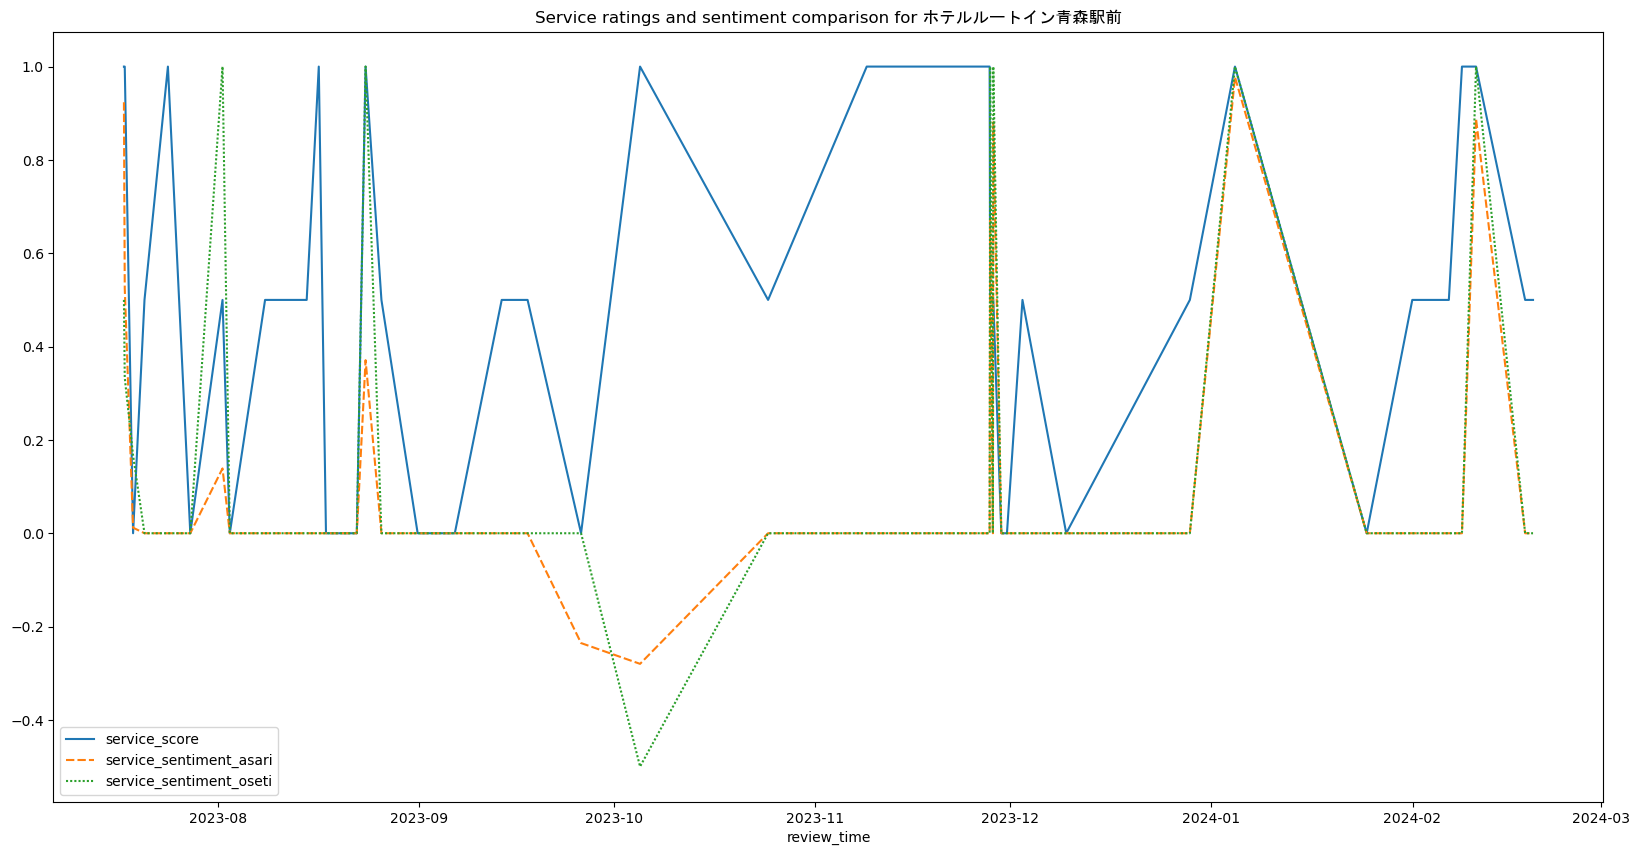

In [31]:
plot_hotel_rating_sentiment_comparison(japanese_reviews_sentiments_df, 
                                       hotel='ホテルルートイン青森駅前',
                                       aspect='service')

In [32]:
def plot_hotel_rating_sentiment_discrete_comparison(dataframe: pd.DataFrame, hotel: str, aspect: str):
    '''Plots line graphs of ratings and sentiments for `aspect` aspect.

    Sentiment scores are directly translated into an integer from 1 to 5, as per the given ratings.
    '''

    # this scales the scores from a range of -1 to 1, to an integer range of 1 to 5
    temp_df = dataframe[dataframe['hotel_name']==hotel].copy()
    temp_df[f'{aspect}_sentiment_asari'] = [np.ceil(2*score + 3) for score in temp_df[f'{aspect}_sentiment_asari'].values.tolist()]
    temp_df[f'{aspect}_sentiment_oseti'] = [np.ceil(2*score + 3) for score in temp_df[f'{aspect}_sentiment_oseti'].values.tolist()]

    # resets index to datetime
    temp_df.set_index('review_time', inplace=True)

    plt.figure(figsize=(20,10))
    # we need MS Gothic in order to render Japanese text in the plot
    # matplotlib will try sans-serif first
    # if the text cannot be rendered in sans-serif
    # then matplotlib tries MS Gothic
    plt.rcParams['font.family'] = ['sans-serif', 'MS Gothic']

    sns.lineplot(temp_df[[f'{aspect}_score', f'{aspect}_sentiment_asari', f'{aspect}_sentiment_oseti']])
    plt.title(f'{aspect.capitalize()} ratings and sentiment comparison for {hotel}')
    ax = plt.gca()
    ax.set_ylim([0, 6])

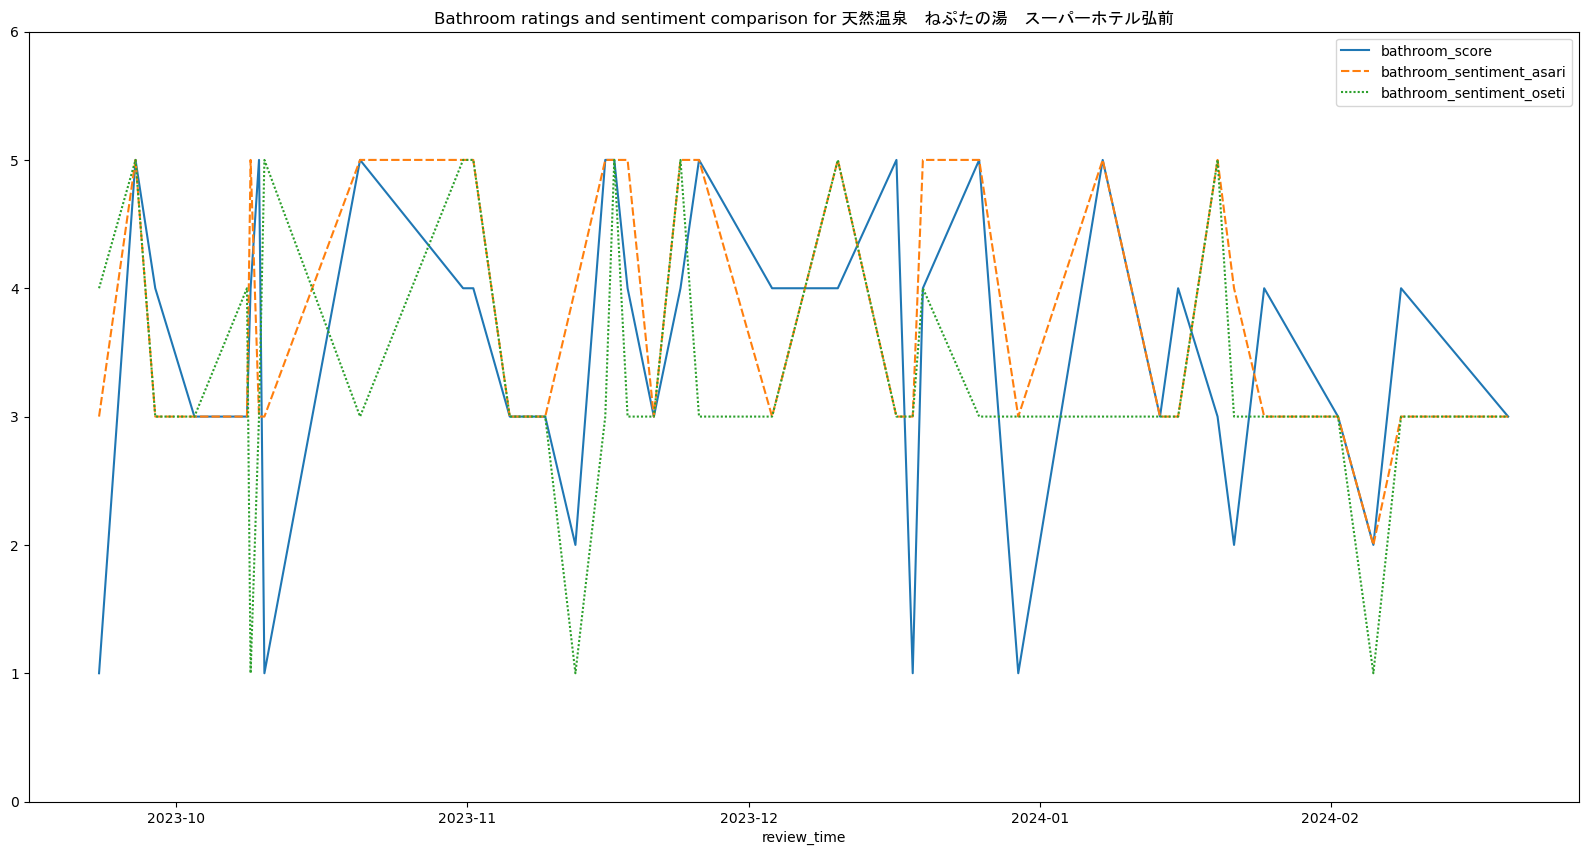

In [33]:
plot_hotel_rating_sentiment_discrete_comparison(japanese_reviews_sentiments_df, 
                                                hotel='天然温泉\u3000ねぷたの湯\u3000スーパーホテル弘前',
                                                aspect='bathroom')

### Quantification of Sentiment Analyzer Performance

In order to properly predict the performace of our two sentiment analyzers, we shall actually convert the sentiment scores to actual ratings. 

As the sentiment scores are in the range $[-1, 1]$, we first scale them into the range $[1,5]$ using the mapping $$x\mapsto 2x+3$$

This is then mapped to an integer from 1 to 5. Due to issues with how numpy's `round` function works, we shall implement a workaround by subtracting 0.5, and then rounding up using `ceil`. The final mapping we shall use is thus: $$f(x)=\lceil 2x+2.5 \rceil$$

In [34]:
def sentiment_to_ratings(row, aspect, analyzer):

    score = row[f'{aspect}_sentiment_{analyzer}']

    # checks for NaN
    if score == score:
        return np.ceil(2*score + 2.5)
    else:
        return np.nan

Now we perform the conversion.

In [35]:
# helper lookup table for easier population
aspect_lookup_table = {
    'all': 'overall',
    'service': 'service',
    'location': 'location',
    'room': 'room',
    'amenities': 'amenities',
    'bathroom': 'bathroom',
    'food': 'food'
}

In [36]:
for aspect in list(aspect_lookup_table.values()):
    for analyzer in ['asari', 'oseti']:
        japanese_reviews_sentiments_df[f'{aspect}_pred_score_{analyzer}'] = japanese_reviews_sentiments_df.apply(sentiment_to_ratings,
                                                                                                                axis=1,
                                                                                                                aspect=aspect,
                                                                                                                analyzer=analyzer)

japanese_reviews_sentiments_df.iloc[:3,-15:]

,food_sentiment_oseti,overall_pred_score_asari,overall_pred_score_oseti,service_pred_score_asari,service_pred_score_oseti,location_pred_score_asari,location_pred_score_oseti,room_pred_score_asari,room_pred_score_oseti,amenities_pred_score_asari,amenities_pred_score_oseti,bathroom_pred_score_asari,bathroom_pred_score_oseti,food_pred_score_asari,food_pred_score_oseti
0,1.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,5.0,5.0,5.0,5.0
1,1.0,5.0,4.0,3.0,3.0,5.0,5.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,5.0
2,0.5,5.0,4.0,3.0,3.0,3.0,3.0,5.0,3.0,3.0,3.0,4.0,5.0,5.0,4.0


Now we can compare how the two sentiment analyzers fare against each other.

In [37]:
non_null_reviews_sentiments_df = japanese_reviews_sentiments_df.drop(columns=['hotel_reply_time', 'hotel_reply_text']).dropna()
for aspect in list(aspect_lookup_table.values()):
    for analyzer in ['asari', 'oseti']:
        print(f'Classification Report for {aspect} ({analyzer})')
        print(classification_report(y_true=non_null_reviews_sentiments_df[f'{aspect}_score'],
                                    y_pred=non_null_reviews_sentiments_df[f'{aspect}_pred_score_{analyzer}']))
        print()

Classification Report for overall (asari)
              precision    recall  f1-score   support

           1       0.30      0.37      0.33        86
           2       0.13      0.16      0.14       139
           3       0.32      0.13      0.19       568
           4       0.47      0.14      0.21      2186
           5       0.54      0.93      0.68      2589

    accuracy                           0.51      5568
   macro avg       0.35      0.35      0.31      5568
weighted avg       0.48      0.51      0.43      5568


Classification Report for overall (oseti)
              precision    recall  f1-score   support

           1       0.03      0.03      0.03        86
           2       0.08      0.14      0.11       139
           3       0.16      0.37      0.22       568
           4       0.36      0.42      0.39      2186
           5       0.51      0.26      0.35      2589

    accuracy                           0.33      5568
   macro avg       0.23      0.25      0.22   

Though both do not perform objectively well, it is clear that `asari` generally performs better across the board compared to `oseti`.

Even though they do not classify the ratings correctly most of the time, let's also see how close they get to the actual ratings, since if the predicted ratings are not too far off from the actual one, it would not be too bad of an estimate. 

The metric we shall use here is the mean absolute error, as we are only concerned with how far off a score is from the actual.

Recall that unlike the classification metrics, the MAE follows the principle of "the smaller, the better".

In [38]:
for aspect in list(aspect_lookup_table.values()):
    for analyzer in ['asari', 'oseti']:
        print(f'Mean absolute error for {aspect} ({analyzer}): {mean_absolute_error(y_true=non_null_reviews_sentiments_df[f"{aspect}_score"],y_pred=non_null_reviews_sentiments_df[f"{aspect}_pred_score_{analyzer}"])}')
    print()

Mean absolute error for overall (asari): 0.6003951149425287
Mean absolute error for overall (oseti): 0.8360272988505747

Mean absolute error for service (asari): 1.008441091954023
Mean absolute error for service (oseti): 1.0549568965517242

Mean absolute error for location (asari): 1.0957255747126438
Mean absolute error for location (oseti): 1.1839080459770115

Mean absolute error for room (asari): 0.953125
Mean absolute error for room (oseti): 1.0725574712643677

Mean absolute error for amenities (asari): 1.0845905172413792
Mean absolute error for amenities (oseti): 1.0867456896551724

Mean absolute error for bathroom (asari): 0.8392600574712644
Mean absolute error for bathroom (oseti): 0.943426724137931

Mean absolute error for food (asari): 0.795617816091954
Mean absolute error for food (oseti): 0.947198275862069



In this respect, `asari` does perform slightly better than `oseti` across all aspects.